# Скачивание центрированных изображений из google maps на локальное хранилище

In [1]:
import requests
import json

import pandas as pd
import numpy as np
import scipy.stats as ss

from tqdm.notebook import tqdm

from google_tile_centered_downloader import download_centered_image, get_tile_center_coords
from google_tile_downloader import download_google_map_tile

## Настройка сессии (аналогичо [google_api_sandbox.ipynb](google_api_sandbox.ipynb))

In [ ]:
API_KEY = <>

url = f'https://tile.googleapis.com/v1/createSession?key={API_KEY}'
headers = {'Content-Type': 'application/json'}
data = {
    'mapType': 'satellite',
    'language': 'en-US',
    'region': 'US'
}

response = requests.post(url, json=data, headers=headers)
session_token = json.loads(response.text)['session']

In [3]:
zoom = 17

## Считываем координаты и скачиваем positive samples

In [ ]:
positives_df_new = pd.read_csv('Eastern_desert_archaeological_structures_NEW.csv', delimiter=',')

In [ ]:
# errors = []
# limit = len(positives_df_new)
# for i in tqdm(range(limit)):
#     id_, name, _, lon, lat, _, _, _, _, _, _, _ = positives_df_new.iloc[i]
#     try:
#         img = download_centered_image(lat=lat, lon=lon, z=zoom, session_token=session_token, api_key=API_KEY)
#         img.save(f'../googlemaps_data/positive_samples/pos_{id_}.png')
#     except Exception as e:
#         print(f'{i=} exception: {e}')
#         errors.append(name)
# print(f'{len(errors)=}')

## Генерируем и сохраняем координаты negative samples

In [ ]:
lon_coords = np.array(positives_df_new['x coordina'])
lat_coords = np.array(positives_df_new['y coordina'])

n = len(lon_coords)
N = 200000

In [ ]:
np.random.seed(42)
weights = np.random.dirichlet(np.ones(n) * 0.2, size=N)

In [ ]:
generated_coords = []
centered_coords = []

for ind in tqdm(range(N)):
    lat = np.dot(lat_coords, weights[ind])
    lon = np.dot(lon_coords, weights[ind])
    generated_coords.append((lat, lon))

    lat_tilecenter, lon_tilecenter = get_tile_center_coords(lat, lon, zoom)
    centered_coords.append((lat_tilecenter, lon_tilecenter))

In [ ]:
# with open('negative_coords_v2.csv', 'w') as f:
#     f.write('img_id,lat,lon\n')
#     for i, (lat, lon) in tqdm(enumerate(centered_coords), total=N):
#         img_id = str(i).zfill(6)
#         f.write(f'{img_id},{lat},{lon}\n')

## Проверяем что все в порядке

In [ ]:
# lat1, lon1 = generated_coords[2]
# lat1, lon1

In [ ]:
# download_centered_image(lat=lat1, lon=lon1, z=zoom, session_token=session_token, api_key=API_KEY)

In [ ]:
# lat2, lon2 = centered_coords[2]
# lat2, lon2

In [ ]:
# download_google_map_tile(lat=lat1, lon=lon1, z=zoom, session_token=session_token, api_key=API_KEY)

In [ ]:
# download_google_map_tile(lat=lat2, lon=lon2, z=zoom, session_token=session_token, api_key=API_KEY)

## Cкачиваем negative samples

In [ ]:
errors = []

In [ ]:
start = 90000
goal = 100000

In [ ]:
# for ind, i in tqdm(enumerate(due), total=len(due)):

#     img_id = str(int(i)).zfill(6)
    
#     try:
#         lat, lon = centered_coords[i]
#         local_file_name = f'negative_samples_v2/{img_id}.png'
#         img = download_google_map_tile(lat=lat, lon=lon, z=zoom, session_token=session_token, api_key=API_KEY)
#         img.save(local_file_name)

#     except Exception as e:
#         print(f'{img_id=}: Exception {e}')
#         errors.append(img_id)
#         continue

In [ ]:
for i in tqdm(range(start, goal)):

    img_id = str(int(i)).zfill(6)
    
    try:
        lat, lon = centered_coords[i]
        local_file_name = f'negative_samples_v2/{img_id}.png'
        img = download_google_map_tile(lat=lat, lon=lon, z=zoom, session_token=session_token, api_key=API_KEY)
        img.save(local_file_name)

    except Exception as e:
        print(f'{img_id=}: Exception {e}')
        errors.append(img_id)
        continue

In [4]:
import os

In [5]:
lst = os.listdir('/home/jupyter/datasphere/project/negative_samples_v2')
len(lst)

99981

## Кладем их на s3

In [ ]:
import boto3
import os
from tqdm.notebook import tqdm

S3_CREDS = {
    'aws_access_key_id' : '<>',
    'aws_secret_access_key' : '<>'
}

bucket = 'archdata'

client = boto3.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    **S3_CREDS
)

In [ ]:
for ind in tqdm(range(start, goal)):
    
    img_id = str(ind).zfill(6)
    
    src_file = f'negative_samples_v2/{img_id}.png'
    dst_file = f'googlemaps_data/negative_v2/negative_samples_v2/{img_id}.png'
    
    client.upload_file(src_file, bucket, dst_file)

In [6]:
lst = os.listdir('/home/jupyter/datasphere/s3/archdata/googlemaps_data/negative_v2/negative_samples_v2')
len(lst)

99945

In [ ]:
indices = [int(s.split('.')[0]) for s in lst]
set(range(goal)).difference(indices)

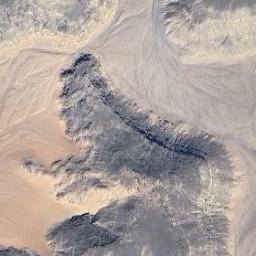

In [7]:
from PIL import Image

img = Image.open('negative_samples_v2/099500.png')
img